In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    roc_auc_score,
    confusion_matrix
)
from sklearn.metrics import roc_curve
import numpy as np

# Load the dataset
file_path = 'german_credit.csv'
data = pd.read_csv(file_path)

# Separate sensitive feature and drop irrelevant columns
sensitive_feature = "Sex"
data = data.drop(columns=["Unnamed: 0", "Age"])

# Split male and female datasets for separate analysis
male_rows = data[data[sensitive_feature] == "male"]
female_rows = data[data[sensitive_feature] == "female"]

# Handle categorical features and preprocess
categorical_features = ["Housing", "Saving accounts", "Checking account", "Purpose"]
numerical_features = ["Job", "Credit amount", "Duration"]

categorical_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot", OneHotEncoder(handle_unknown="ignore")),
])

numerical_transformer = SimpleImputer(strategy="mean")

preprocessor = ColumnTransformer(
    transformers=[
        ("num", numerical_transformer, numerical_features),
        ("cat", categorical_transformer, categorical_features),
    ]
)

# Define the model pipeline
model = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("classifier", GradientBoostingClassifier(random_state=42)),
])

# Prepare the entire dataset for training
X = data.drop(["Risk", sensitive_feature], axis=1)
y = data["Risk"].apply(lambda x: 1 if x == "good" else 0)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train the model
model.fit(X_train, y_train)

# Predict on the test set
y_pred = model.predict(X_test)
y_prob = model.predict_proba(X_test)[:, 1]

# Baseline metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_prob)

print(f"Accuracy: {accuracy:.2f}")
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1 Score: {f1:.2f}")
print(f"ROC-AUC: {roc_auc:.2f}")

# Evaluate fairness metrics
def fairness_metrics(group, label="good"):
    group_X = group.drop(["Risk", sensitive_feature], axis=1)
    group_y = group["Risk"].apply(lambda x: 1 if x == label else 0)
    group_pred = model.predict(group_X)
    group_tp = ((group_y == 1) & (group_pred == 1)).sum()
    group_fp = ((group_y == 0) & (group_pred == 1)).sum()
    group_fn = ((group_y == 1) & (group_pred == 0)).sum()
    group_tn = ((group_y == 0) & (group_pred == 0)).sum()

    approval_rate = (group_pred == 1).mean()
    true_positive_rate = group_tp / (group_tp + group_fn)
    false_positive_rate = group_fp / (group_fp + group_tn)

    return approval_rate, true_positive_rate, false_positive_rate

# Male and female fairness metrics
male_approval, male_tpr, male_fpr = fairness_metrics(male_rows)
female_approval, female_tpr, female_fpr = fairness_metrics(female_rows)

# Disparate Impact (DI)
di = male_approval / female_approval if female_approval > 0 else np.nan

# Equalized Odds
equalized_odds_tpr = abs(male_tpr - female_tpr)
equalized_odds_fpr = abs(male_fpr - female_fpr)

print(f"\nFairness Metrics:")
print(f"Male Approval Rate: {male_approval:.2f}")
print(f"Female Approval Rate: {female_approval:.2f}")
print(f"Disparate Impact (DI): {di:.2f}")
print(f"Equalized Odds - TPR Difference: {equalized_odds_tpr:.2f}")
print(f"Equalized Odds - FPR Difference: {equalized_odds_fpr:.2f}")

# Behavior analysis using feature importance
feature_importance = model.named_steps["classifier"].feature_importances_
feature_names = numerical_features + list(model.named_steps["preprocessor"].named_transformers_["cat"].named_steps["onehot"].get_feature_names_out())
importance_df = pd.DataFrame({
    "Feature": feature_names,
    "Importance": feature_importance
}).sort_values(by="Importance", ascending=False)

print("\nFeature Importance:")
print(importance_df)

Accuracy: 0.72
Precision: 0.74
Recall: 0.92
F1 Score: 0.82
ROC-AUC: 0.70

Fairness Metrics:
Male Approval Rate: 0.86
Female Approval Rate: 0.82
Disparate Impact (DI): 1.04
Equalized Odds - TPR Difference: 0.00
Equalized Odds - FPR Difference: 0.01

Feature Importance:
                   Feature  Importance
1            Credit amount    0.464100
2                 Duration    0.217792
4                   x0_own    0.047441
0                      Job    0.031128
17  x3_furniture/equipment    0.029724
18             x3_radio/TV    0.025474
14                  x3_car    0.024654
11             x2_moderate    0.023762
13             x3_business    0.021921
16            x3_education    0.020468
3                  x0_free    0.014916
19              x3_repairs    0.014797
5                  x0_rent    0.014618
7              x1_moderate    0.014265
6                x1_little    0.012790
9                  x1_rich    0.008424
10               x2_little    0.006922
20      x3_vacation/others   

In [ ]:
import pandas as pd
from sklearn.metrics import confusion_matrix, brier_score_loss

# Define fairness metrics
def group_metrics(group, label="good"):
    group_X = group.drop(["Risk", sensitive_feature], axis=1)
    group_y = group["Risk"].apply(lambda x: 1 if x == label else 0)
    group_pred = model.predict(group_X)
    group_prob = model.predict_proba(group_X)[:, 1]

    cm = confusion_matrix(group_y, group_pred)
    tn, fp, fn, tp = cm.ravel()

    approval_rate = (group_pred == 1).mean()
    true_positive_rate = tp / (tp + fn) if (tp + fn) > 0 else 0
    false_positive_rate = fp / (fp + tn) if (fp + tn) > 0 else 0
    false_negative_rate = fn / (tp + fn) if (tp + fn) > 0 else 0
    calibration = brier_score_loss(group_y, group_prob)

    return approval_rate, true_positive_rate, false_positive_rate, false_negative_rate, calibration

# Fairness analysis for males and females
male_metrics = group_metrics(male_rows)
female_metrics = group_metrics(female_rows)

# Extract metrics
(
    male_approval,
    male_tpr,
    male_fpr,
    male_fnr,
    male_calibration,
) = male_metrics

(
    female_approval,
    female_tpr,
    female_fpr,
    female_fnr,
    female_calibration,
) = female_metrics

# Demographic Parity Difference
dp_difference = abs(male_approval - female_approval)

# Brier Score Calibration Difference
calibration_diff = abs(male_calibration - female_calibration)

# Output Results
print("\nFairness and Misalignment Metrics:")
print(f"Male Approval Rate: {male_approval:.2f}")
print(f"Female Approval Rate: {female_approval:.2f}")
print(f"Demographic Parity Difference: {dp_difference:.2f}")
print(f"Male TPR: {male_tpr:.2f}, Female TPR: {female_tpr:.2f}")
print(f"Male FPR: {male_fpr:.2f}, Female FPR: {female_fpr:.2f}")
print(f"Male FNR: {male_fnr:.2f}, Female FNR: {female_fnr:.2f}")
print(f"Male Calibration (Brier Score): {male_calibration:.2f}")
print(f"Female Calibration (Brier Score): {female_calibration:.2f}")
print(f"Calibration Difference: {calibration_diff:.2f}")

# Optional: Visualize cumulative fairness/opportunity
fairness_scores = pd.DataFrame({
    "Metric": ["Approval Rate", "TPR", "FPR", "FNR", "Calibration"],
    "Male": [male_approval, male_tpr, male_fpr, male_fnr, male_calibration],
    "Female": [female_approval, female_tpr, female_fpr, female_fnr, female_calibration],
    "Difference": [
        abs(male_approval - female_approval),
        abs(male_tpr - female_tpr),
        abs(male_fpr - female_fpr),
        abs(male_fnr - female_fnr),
        calibration_diff,
    ],
})
print("\nCumulative Fairness Scores:")
print(fairness_scores)



Fairness and Misalignment Metrics:
Male Approval Rate: 0.86
Female Approval Rate: 0.82
Demographic Parity Difference: 0.03
Male TPR: 0.97, Female TPR: 0.97
Male FPR: 0.54, Female FPR: 0.55
Male FNR: 0.03, Female FNR: 0.03
Male Calibration (Brier Score): 0.13
Female Calibration (Brier Score): 0.15
Calibration Difference: 0.02

Cumulative Fairness Scores:
          Metric      Male    Female  Difference
0  Approval Rate  0.855072  0.822581    0.032492
1            TPR  0.973948  0.970149    0.003799
2            FPR  0.544503  0.550459    0.005956
3            FNR  0.026052  0.029851    0.003799
4    Calibration  0.130422  0.149858    0.019436


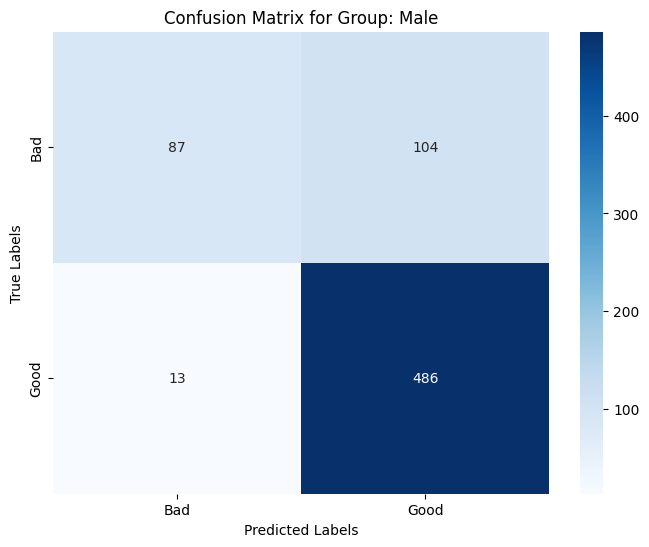

Classification Report for Male:
              precision    recall  f1-score   support

           0       0.87      0.46      0.60       191
           1       0.82      0.97      0.89       499

    accuracy                           0.83       690
   macro avg       0.85      0.71      0.75       690
weighted avg       0.84      0.83      0.81       690

True Positive Rate (TPR) for Male: 0.97
False Positive Rate (FPR) for Male: 0.54


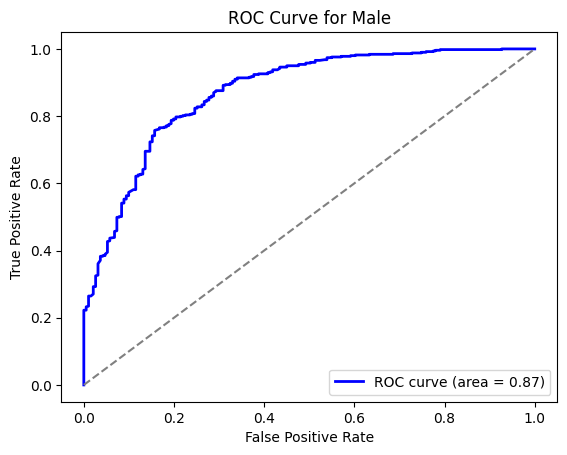

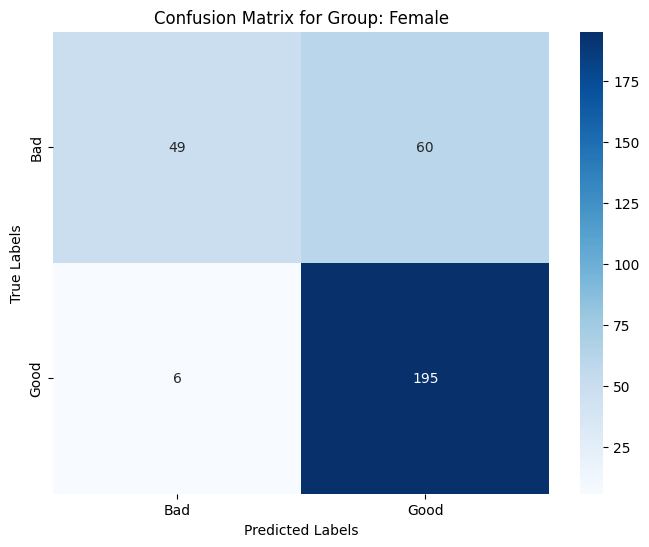

Classification Report for Female:
              precision    recall  f1-score   support

           0       0.89      0.45      0.60       109
           1       0.76      0.97      0.86       201

    accuracy                           0.79       310
   macro avg       0.83      0.71      0.73       310
weighted avg       0.81      0.79      0.76       310

True Positive Rate (TPR) for Female: 0.97
False Positive Rate (FPR) for Female: 0.55


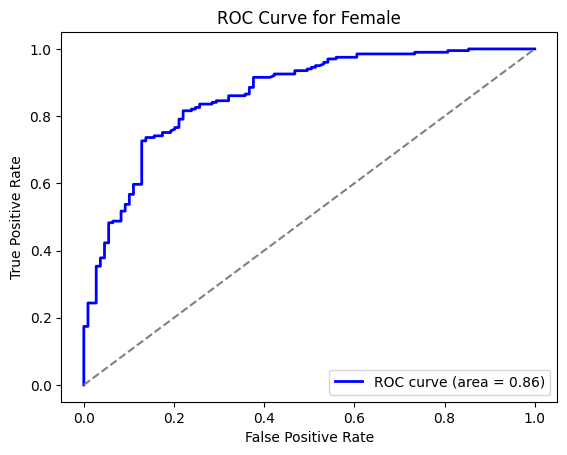


Summary of Group Performance:
Male: TPR = 0.97, FPR = 0.54, AUC = 0.87
Female: TPR = 0.97, FPR = 0.55, AUC = 0.86


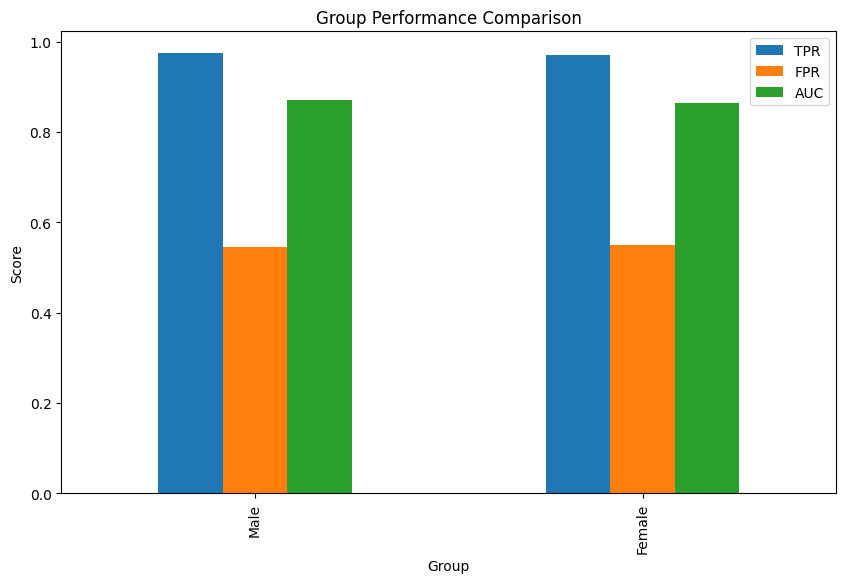

In [ ]:
import pandas as pd
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import roc_curve, auc

# Function to print confusion matrix
def print_confusion_matrix(cm, group_name, class_names=["Bad", "Good"]):
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
    plt.xlabel("Predicted Labels")
    plt.ylabel("True Labels")
    plt.title(f"Confusion Matrix for Group: {group_name}")
    plt.show()

# Function to compute and print metrics for a group
def group_performance(data_group, group_name):
    X_group = data_group.drop(["Risk", sensitive_feature], axis=1)
    y_group = data_group["Risk"].apply(lambda x: 1 if x == "good" else 0)

    y_pred_group = model.predict(X_group)
    y_prob_group = model.predict_proba(X_group)[:, 1]

    # Confusion Matrix
    cm = confusion_matrix(y_group, y_pred_group)
    print_confusion_matrix(cm, group_name)

    # Extract metrics
    TN, FP, FN, TP = cm.ravel()
    TPR = TP / (TP + FN) if (TP + FN) > 0 else 0
    FPR = FP / (FP + TN) if (FP + TN) > 0 else 0

    # Classification report
    print(f"Classification Report for {group_name}:")
    print(classification_report(y_group, y_pred_group))

    # True Positive Rate (TPR) and False Positive Rate (FPR)
    print(f"True Positive Rate (TPR) for {group_name}: {TPR:.2f}")
    print(f"False Positive Rate (FPR) for {group_name}: {FPR:.2f}")

    # ROC Curve
    fpr, tpr, _ = roc_curve(y_group, y_prob_group)
    roc_auc = auc(fpr, tpr)
    plt.figure()
    plt.plot(fpr, tpr, color="blue", lw=2, label=f"ROC curve (area = {roc_auc:.2f})")
    plt.plot([0, 1], [0, 1], color="gray", linestyle="--")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title(f"ROC Curve for {group_name}")
    plt.legend(loc="lower right")
    plt.show()

    return {
        "TPR": TPR,
        "FPR": FPR,
        "AUC": roc_auc
    }

# Analyze performance for males and females
male_results = group_performance(male_rows, "Male")
female_results = group_performance(female_rows, "Female")

# Print summary of group performance
print("\nSummary of Group Performance:")
print(f"Male: TPR = {male_results['TPR']:.2f}, FPR = {male_results['FPR']:.2f}, AUC = {male_results['AUC']:.2f}")
print(f"Female: TPR = {female_results['TPR']:.2f}, FPR = {female_results['FPR']:.2f}, AUC = {female_results['AUC']:.2f}")

# Compare group performance visually
performance_df = pd.DataFrame({
    "Group": ["Male", "Female"],
    "TPR": [male_results["TPR"], female_results["TPR"]],
    "FPR": [male_results["FPR"], female_results["FPR"]],
    "AUC": [male_results["AUC"], female_results["AUC"]]
})

performance_df.plot(x="Group", y=["TPR", "FPR", "AUC"], kind="bar", figsize=(10, 6), title="Group Performance Comparison")
plt.ylabel("Score")
plt.show()
